In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 300
num_folds = 5

def split_text(text):
    return text.split(' ')

def prepare_sequences():
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [("question_text", TEXT), ("target", LABEL)]
    fold_names = ['train_fold{}.csv'.format(i) for i in range(1,num_folds+1)]
    train_folds = []
    for fold in fold_names:
        train_folds.append(torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=fold, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
                )
            )
    test_datafields = [('qid', QID),("question_text", TEXT)]
    test = torchtext.data.TabularDataset( 
                    path='test.csv',
                    format="csv",
                    skip_header=True,
                    fields=test_datafields
                    )
    return TEXT, LABEL, train_folds, test

TEXT, LABEL, train, test = prepare_sequences()
vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(*train,test, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       
train_fold_loader = []
for fold in train:
    train_fold_loader.append(BucketIterator(
         fold, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )
    )
test_loader = BucketIterator(
         test, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

In [10]:
def validation(loader, test_set, predictions):
    accuracy = 0
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = bid_lstm_cnn(gpu)
            target = batch.target.numpy()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            total_correct = sum(target == preds)

            act = np.concatenate((act, target))
            pred = np.concatenate((pred, preds))

            accuracy += total_correct
            num_batches += 1
            torch.cuda.empty_cache()
            del gpu, target, preds
        count = 0
        for batch in test_set:
            qid = batch.qid
            question = batch.question_text.to(device).long()
            preds = bid_lstm_cnn(question)
            preds = preds.cpu().detach().numpy()
            for idx, ID in enumerate(qid):
                predictions[ID.item()].append(preds[idx])
            torch.cuda.empty_cache()
            del qid, question, preds
            count+=1
    acc = accuracy / (num_batches * batch_size)
    print('Accuracy ->',acc)
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return acc, formula1

def plot():
    plt.scatter([i for i in range(len(accuracy_fold))], f1_fold, label = 'F1 Training set')
    a = 0
    for r in f1_fold:
        a += r
    a /= len(f1_fold)
    plt.plot([i for i in range(len(accuracy_fold))], [a for i in range(len(accuracy_fold))], label = 'Avg fold f1 = {0:.3f}'.format(float(a)))
    plt.legend()
    plt.title('5 Fold Cross-validation F1 score bilstm cnn')
    plt.xlabel('Fold held out')
    plt.ylabel('F1 Score')
    plt.show()

def train_model(batch):
    bid_lstm_cnn.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = bid_lstm_cnn(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [4]:
class bidirec_lstm_1dcnn(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 num_channels, #num channels
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(bidirec_lstm_1dcnn, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        
        self.conv = nn.Conv1d(1, 
                              num_channels,
                              kernel_size)
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        # 2 for bi direction
        self.output_size = 2*(self.hidden_size - self.kernel_size)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels+2)
        self.layer = nn.Linear(self.output_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        
        #formating output from lstm to be of id conv size
        inpt = inpt[-1,:,:].view(batch_size,1, self.hidden_size * 2)
        
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

  0%|          | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++
Fold -> 0
	Epoch 1/8	AVG loss: 0.2304555800851396	Total loss:802.9072410166264
	Epoch 2/8	AVG loss: 0.21963010738624086	Total loss:765.1912941336632
	Epoch 3/8	AVG loss: 0.11368035375601457	Total loss:396.06235248595476
	Epoch 4/8	AVG loss: 0.09707816214708079	Total loss:338.22031692042947
	Epoch 5/8	AVG loss: 0.08454183220700816	Total loss:294.5437434092164
Accuracy -> 0.9573517030233448
f1 -> 0.6401820546163848


 20%|██        | 1/5 [31:16<2:05:06, 1876.50s/it]

True positives -> 9846
False positives -> 4752
True negatives -> 240310
False negatives -> 6316

++++++++++++++++++++++++++++++++++++++++
Fold -> 1
	Epoch 1/8	AVG loss: 0.13145502938661216	Total loss:457.98932238295674
	Epoch 2/8	AVG loss: 0.10437627860807934	Total loss:363.64695467054844
	Epoch 3/8	AVG loss: 0.09115561505888688	Total loss:317.5861628651619
	Epoch 4/8	AVG loss: 0.0793269697542545	Total loss:276.3751626238227
	Epoch 5/8	AVG loss: 0.06838850363293485	Total loss:238.26554665714502
Accuracy -> 0.9558055874473785
f1 -> 0.6403310759969902


 40%|████      | 2/5 [1:03:50<1:34:59, 1899.88s/it]

True positives -> 10212
False positives -> 5522
True negatives -> 239540
False negatives -> 5950

++++++++++++++++++++++++++++++++++++++++
Fold -> 2
	Epoch 1/8	AVG loss: 0.1683908005145589	Total loss:586.6735489927232
	Epoch 2/8	AVG loss: 0.108828213800442	Total loss:379.1574968807399
	Epoch 3/8	AVG loss: 0.09611573980759773	Total loss:334.8672374896705
	Epoch 4/8	AVG loss: 0.08500939935935505	Total loss:296.172747367993
	Epoch 5/8	AVG loss: 0.07367079920668998	Total loss:256.6690644361079
Accuracy -> 0.9547455032529659
f1 -> 0.632096445905746


 60%|██████    | 3/5 [1:36:24<1:03:52, 1916.11s/it]

True positives -> 10093
False positives -> 5680
True negatives -> 239382
False negatives -> 6069

++++++++++++++++++++++++++++++++++++++++
Fold -> 3
	Epoch 1/8	AVG loss: 0.22210625113853083	Total loss:773.8181789666414
	Epoch 2/8	AVG loss: 0.11533385297940053	Total loss:401.8231437802315
	Epoch 3/8	AVG loss: 0.0986626387512831	Total loss:343.7406334094703
	Epoch 4/8	AVG loss: 0.08605034476152518	Total loss:299.7994011491537
	Epoch 5/8	AVG loss: 0.07527079630106362	Total loss:262.24345431290567
Accuracy -> 0.9551435132032147
f1 -> 0.6379605160889165


 80%|████████  | 4/5 [2:08:47<32:04, 1924.09s/it]  

True positives -> 10260
False positives -> 5743
True negatives -> 239319
False negatives -> 5902

++++++++++++++++++++++++++++++++++++++++
Fold -> 4
	Epoch 1/8	AVG loss: 0.17862478171044321	Total loss:622.3287394791842
	Epoch 2/8	AVG loss: 0.11033839965827258	Total loss:384.4189844094217
	Epoch 3/8	AVG loss: 0.09734478317645949	Total loss:339.14922458678484
	Epoch 4/8	AVG loss: 0.08612481744566464	Total loss:300.0588639806956
	Epoch 5/8	AVG loss: 0.0761424169648999	Total loss:265.28018070571125
Accuracy -> 0.9554611557596632
f1 -> 0.6182646592709984


100%|██████████| 5/5 [2:41:15<00:00, 1931.32s/it]

True positives -> 9363
False positives -> 4763
True negatives -> 240299
False negatives -> 6799



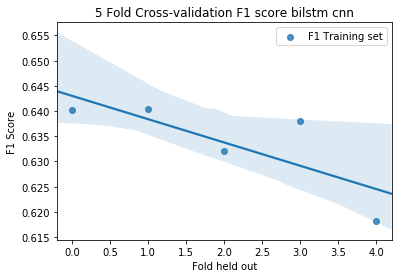

In [5]:
verbose = 100

#Model parameters
input_size = 300
hidden_dim = 300
num_layers = 2
num_channels = 70
kernel_size = 1
pool_size = 100
dropout = 0.1

epoch = 5

#Evaluation metrics for model
accuracy_fold = []
f1_fold = []
avg_error = []
preds = {i:[] for i in range(375806)}

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

from tqdm import tqdm
for i in tqdm(range(num_folds)): 
    try:
        bid_lstm_cnn = bidirec_lstm_1dcnn(input_size, hidden_dim, num_layers, num_channels, kernel_size, pool_size, dropout).cuda()
    except:
        bid_lstm_cnn = bidirec_lstm_1dcnn(input_size, hidden_dim, num_layers, num_channels, kernel_size, pool_size, dropout).cuda()

    optimizer = optim.Adam(bid_lstm_cnn.parameters())
    criterion = nn.BCELoss()
    
    train_folds = []
    
    for j in range(num_folds): 
        if j != i:
            train_folds.append(train_fold_loader[j])
        else: 
            val_fold = train_fold_loader[j]
    bid_lstm_cnn.train()
    print('++++++++++++++++++++++++++++++++++++++++')
    print('Fold -> {}'.format(i))
    for e in range(1, epoch+1):
        total_error = 0
        num = 0
        np.random.shuffle(train_folds)
        for fold in train_folds:
            for batch in fold:
                loss = train_model(batch)
                total_error += loss
                torch.cuda.empty_cache()
            num += 1
            torch.cuda.empty_cache()
        avg_loss = total_error/(len(train_folds)*len(train_folds[0]))
        print('\tEpoch {}/8\tAVG loss: {}\tTotal loss:{}'.format(e, avg_loss, total_error))
        torch.cuda.empty_cache()
        avg_error.append(avg_loss)
    bid_lstm_cnn.eval()
    acc, f = validation(val_fold, test_loader, preds)
    accuracy_fold.append(acc)
    f1_fold.append(f)
    torch.cuda.empty_cache()
plot()

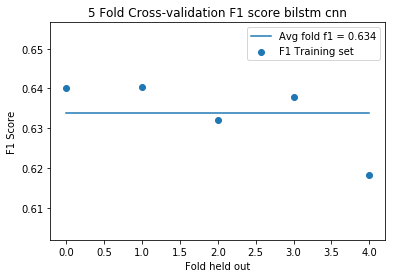

In [11]:
plot()

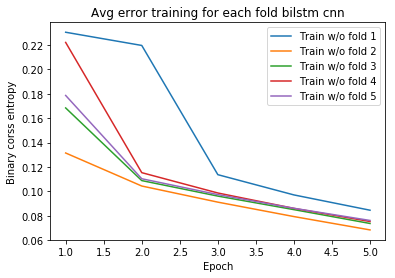

In [6]:
start = 0
end = 5
for i in range(5):
    plt.plot([i for i in range(1,6)], avg_error[start:end], label = 'Train w/o fold {}'.format(i+1))
    start = end
    end+=5
plt.title('Avg error training for each fold bilstm cnn')
plt.legend()
plt.ylabel('Binary corss entropy')
plt.xlabel('Epoch')
plt.show()

In [7]:
with open('results_lstm_cnn.txt', mode = 'w') as f: 
    for key in preds.keys():
        f.write(str(key))
        for val in preds[key]:
            f.write(' {}'.format(str(val)))
        f.write('\n')

In [ ]:
predictions = {}
for key in preds.keys(): 
    threshold = 0.8
    temp = []
    for val in preds[key]:
        temp.append(val > threshold)
    temp = sum(temp)
    if temp > 2: 
        predictions[key] = 1
    else:
        predictions[key] = 0
predictions = sorted(predictions.items())

In [ ]:
predictions = [x[1] for x in predictions]
qid = pd.read_csv('data/qid.csv')
sub = {'qid':list(qid.qid), 'prediction':predictions}
submission_ = pd.DataFrame.from_dict(sub)

In [ ]:
actual = pd.read_csv('submission.csv')
flagged = submission_[submission_.prediction == 1]
act_flagged = actual[actual.prediction == 1]
found = 0
for i in act_flagged.index: 
    if submission_.prediction.iloc[i] == 1:
        found += 1
print(found)

In [ ]:
with open('preds.txt', mode = 'w') as f: 
    f.write('import pandas as pd \n')
    f.write('pred = [')
    count = 0
    written = 0
    #replace data -> pd dataframe
    for ind in submission_.index: 
        if count < 40:
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count += 1
            written += 1
        else: 
            f.write('\n')
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count = 0
            written += 1
    f.write(']\n')
    f.write('test = pd.read_csv(\'../input/test.csv\').qid\n')
    f.write('sub = {\'qid\':[], \'prediction\':[]}\n')

    f.write('for i in range(len(pred)):\n')
    f.write('\tsub[\'qid\'].append(test.iloc[i])\n')
    f.write('\tsub[\'prediction\'].append(pred[i])\n')
    f.write('sub = pd.DataFrame.from_dict(sub)\n')
    f.write('sub.to_csv(\'submission.csv\', index=False)')